In [1]:
import os
import numpy as np
import glob
import random
import imageio
import PIL, cv2
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPool2D, Dropout, Flatten , Activation ,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from keras import models,layers
from keras.src.utils.np_utils import to_categorical
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
import matplotlib.image as mpimg
import skimage
import math
from scipy.ndimage.filters import convolve
from PIL import Image,ImageFilter
from skimage.feature import hessian_matrix, hessian_matrix_eigvals

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#DATA_DIR = "../content/drive/MyDrive/fingerprint/input/Altered/Altered-Hard/"
#list_dirs = list(glob.glob(DATA_DIR+"*.BMP"))
#num_images = len(list_dirs)

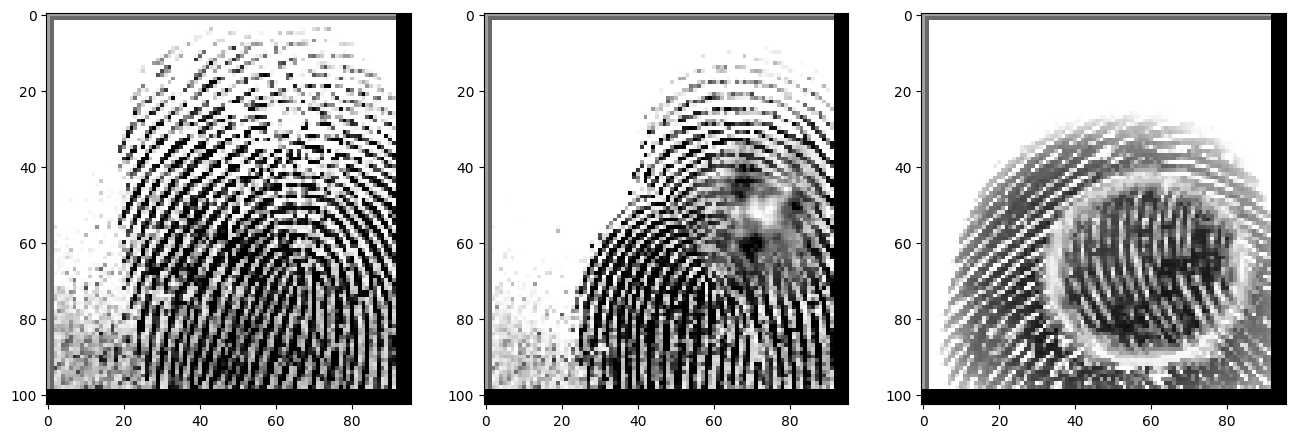

In [4]:
#random.seed(42)

#r = random.randint(0,num_images)
display_list_0 = "../content/drive/MyDrive/fingerprint/input/Real/10__M_Left_index_finger.BMP"
display_list_1= "../content/drive/MyDrive/fingerprint/input/Altered/Altered-Medium/10__M_Left_little_finger_Obl.BMP"
display_list_2 = "../content/drive/MyDrive/fingerprint/input/Altered/Altered-Hard/3__M_Left_index_finger_CR.BMP"

image1 = cv2.imread(display_list_0)
image2 = cv2.imread(display_list_1)
image3 = cv2.imread(display_list_2)

fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].imshow(image1);
axes[1].imshow(image2);
axes[2].imshow(image3);

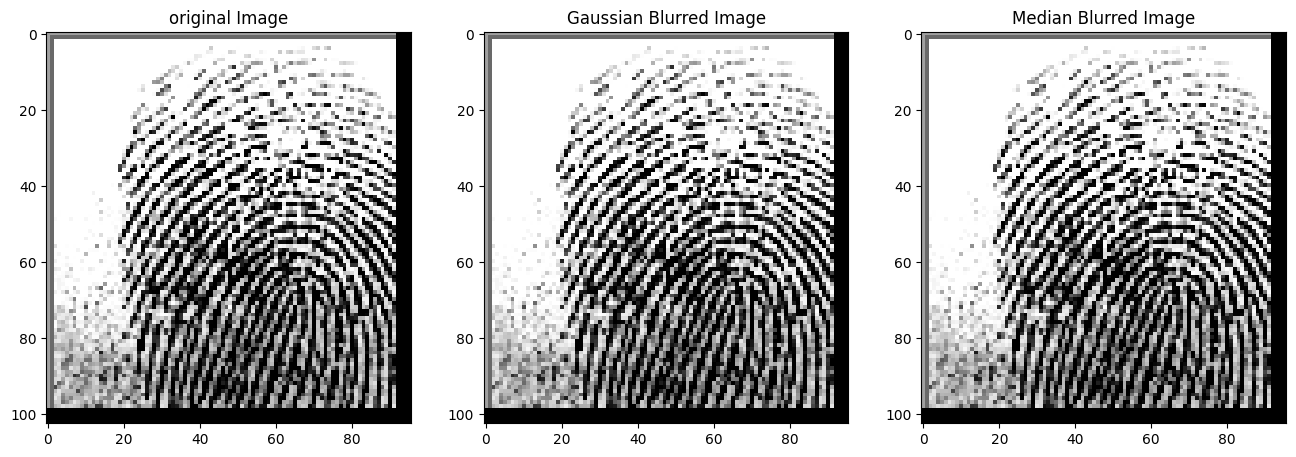

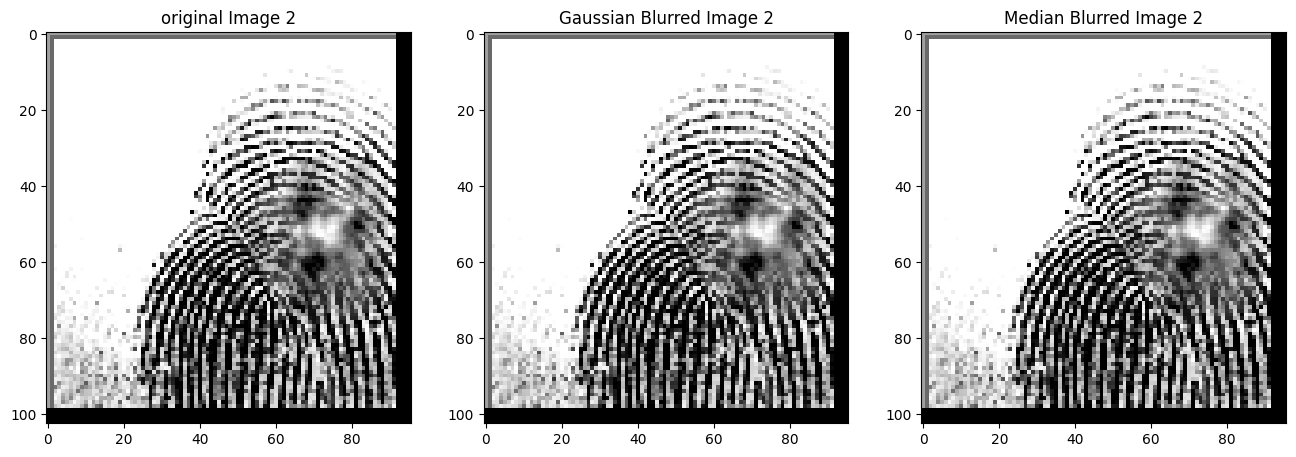

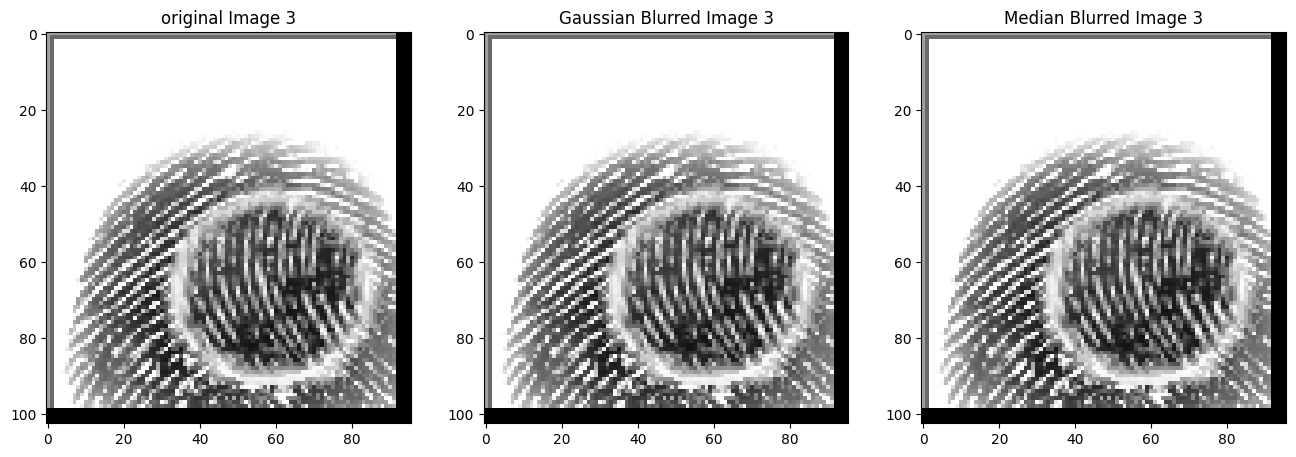

In [5]:
gauss_blur = cv2.GaussianBlur(image1,(1,1),0)
median_blur = cv2.medianBlur(image1,1)

gauss_blur2 = cv2.GaussianBlur(image2,(1,1),0)
median_blur2 = cv2.medianBlur(image2,1)

gauss_blur3 = cv2.GaussianBlur(image3,(1,1),0)
median_blur3 = cv2.medianBlur(image3,1)

fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].set_title("original Image");
axes[0].imshow(image1);
axes[1].set_title("Gaussian Blurred Image");
axes[1].imshow(gauss_blur);
axes[2].set_title("Median Blurred Image");
axes[2].imshow(median_blur);
fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].set_title("original Image 2");
axes[0].imshow(image2);
axes[1].set_title("Gaussian Blurred Image 2");
axes[1].imshow(gauss_blur2);
axes[2].set_title("Median Blurred Image 2");
axes[2].imshow(median_blur2);
fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].set_title("original Image 3");
axes[0].imshow(image3);
axes[1].set_title("Gaussian Blurred Image 3");
axes[1].imshow(gauss_blur3);
axes[2].set_title("Median Blurred Image 3");
axes[2].imshow(median_blur3);

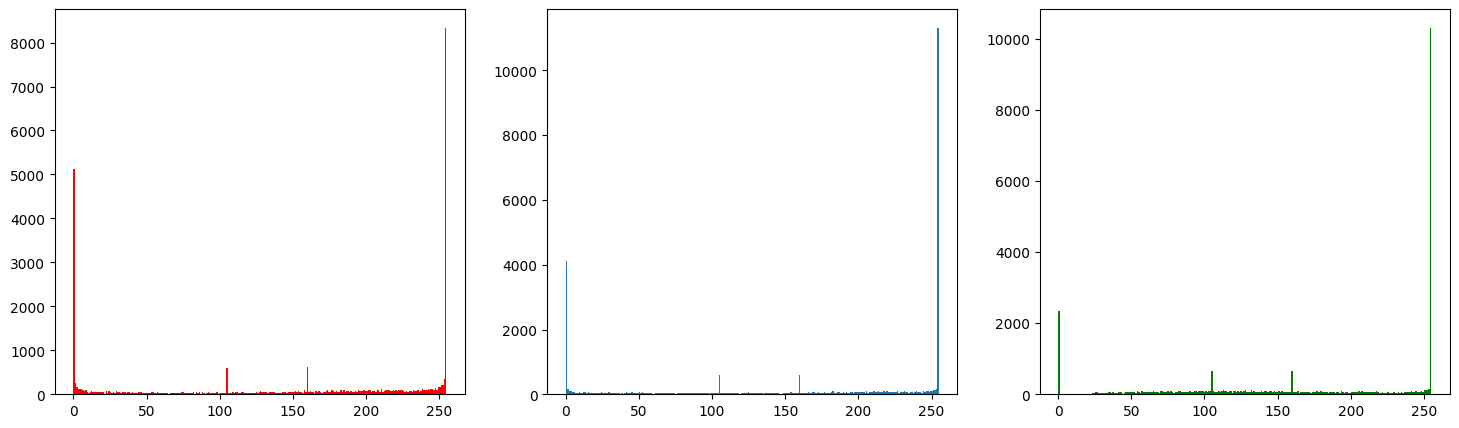

In [6]:
fig, axes = plt.subplots(1,3,figsize = (18,5))
axes[0].hist(image1.ravel(), bins=256, color ="r");
axes[1].hist(image2.ravel(), bins=256);
axes[2].hist(image3.ravel(), bins=256, color ="g");

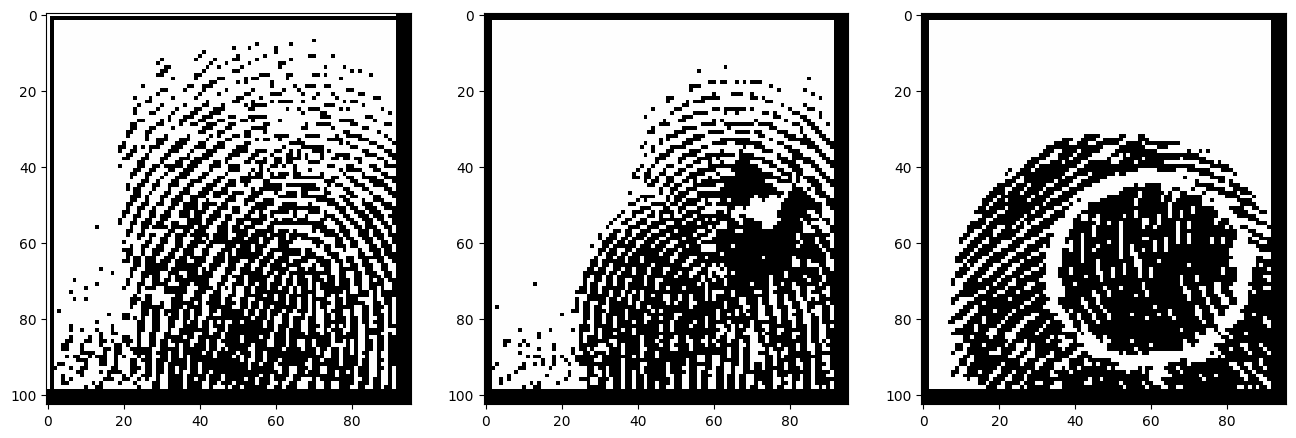

In [7]:
# mean thresholding - gives bad results
THRESHOLD1 = image1.mean()
THRESHOLD2 = image2.mean()
THRESHOLD3 = image3.mean()

image1 = np.array(image1 > THRESHOLD1).astype(int) * 254
image2 = np.array(image2 > THRESHOLD2).astype(int) * 254
image3 = np.array(image3 > THRESHOLD3).astype(int) * 254

fig, axes = plt.subplots(1,3,figsize = (16,16));
axes[0].imshow(image1);
axes[1].imshow(image2);
axes[2].imshow(image3);

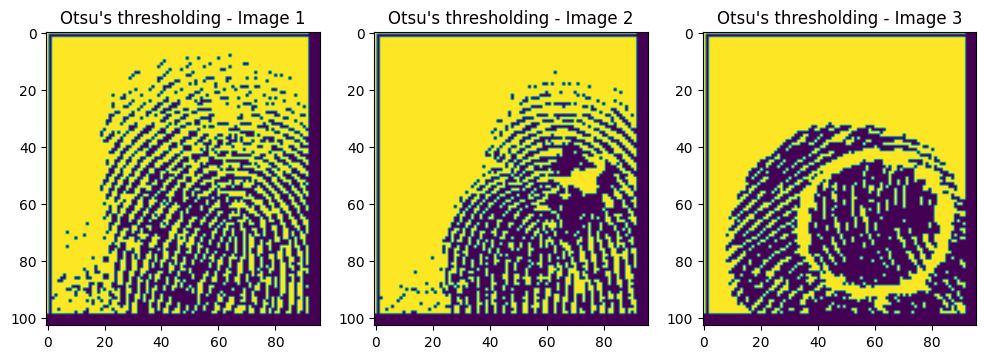

In [8]:
# Adaptive thresholding from OpenCV library - better than Mean Thresholding

img1 = cv2.imread(display_list_0,0)
img2 = cv2.imread(display_list_1,0)
img3 = cv2.imread(display_list_2,0)

# Otsu's thresholding
ret1,th1 = cv2.threshold(img1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2,th2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret3,th3 = cv2.threshold(img3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

fig, axes = plt.subplots(1,3,figsize = (12,12));
axes[0].set_title("Otsu's thresholding - Image 1");
axes[0].imshow(th1);
axes[1].set_title("Otsu's thresholding - Image 2");
axes[1].imshow(th2);
axes[2].set_title("Otsu's thresholding - Image 3");
axes[2].imshow(th3);

In [9]:
# convert to grayscale
img_name = display_list_0
gray_img_array = np.array(Image.open(img_name).convert('P'))
img_name = display_list_1
gray_img_array = np.array(Image.open(img_name).convert('P'))
img_name = display_list_2
gray_img_array = np.array(Image.open(img_name).convert('P'))

In [10]:
#Edge detection

vertical_robert_filter = np.array([[1,0],[0,-1]])
horizontal_robert_filter = np.array([[0,1],[-1,0]])

vertical_sobel_filter = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
horizontal_sobel_filter = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])

vertical_prewitt_filter = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
horizontal_prewitt_filter = np.array([[-1,-1,-1],[0,0,0],[1,1,1]])

print("vertical robert filter\n",vertical_robert_filter )
print("horizontal robert filter\n",horizontal_robert_filter)
print("vertical sobel filter: \n", vertical_sobel_filter)
print("horizontal sobel filter: \n", horizontal_sobel_filter)

print("vertical prewitt filter: \n", vertical_prewitt_filter)
print("horizontal prewitt filter: \n", horizontal_prewitt_filter)

vertical robert filter
 [[ 1  0]
 [ 0 -1]]
horizontal robert filter
 [[ 0  1]
 [-1  0]]
vertical sobel filter: 
 [[-1  0  1]
 [-2  0  2]
 [-1  0  1]]
horizontal sobel filter: 
 [[-1 -2 -1]
 [ 0  0  0]
 [ 1  2  1]]
vertical prewitt filter: 
 [[-1  0  1]
 [-1  0  1]
 [-1  0  1]]
horizontal prewitt filter: 
 [[-1 -1 -1]
 [ 0  0  0]
 [ 1  1  1]]


In [11]:
# implementing:
gray_img = Image.fromarray(gray_img_array)

convolved_img1_1 = convolve(gray_img,vertical_robert_filter)
convolved_img1_1 = convolve(convolved_img1_1,horizontal_robert_filter)

convolved_img1_2 = convolve(gray_img,vertical_sobel_filter)
convolved_img1_2 = convolve(convolved_img1_2,horizontal_sobel_filter)

convolved_img1_3 =  convolve(gray_img,vertical_prewitt_filter )
convolved_img1_3 =  convolve(gray_img,horizontal_prewitt_filter )

convolved_img2_1 = convolve(gray_img,vertical_robert_filter)
convolved_img2_1 = convolve(convolved_img2_1,horizontal_robert_filter)

convolved_img2_2 = convolve(gray_img,vertical_sobel_filter)
convolved_img2_2 = convolve(convolved_img2_2,horizontal_sobel_filter)

convolved_img2_3 =  convolve(gray_img,vertical_prewitt_filter )
convolved_img2_3 =  convolve(gray_img,horizontal_prewitt_filter )

convolved_img3_1 = convolve(gray_img,vertical_robert_filter)
convolved_img3_1 = convolve(convolved_img3_1,horizontal_robert_filter)

convolved_img3_2 = convolve(gray_img,vertical_sobel_filter)
convolved_img3_2 = convolve(convolved_img3_2,horizontal_sobel_filter)

convolved_img3_3 =  convolve(gray_img,vertical_prewitt_filter )
convolved_img3_3 =  convolve(gray_img,horizontal_prewitt_filter )

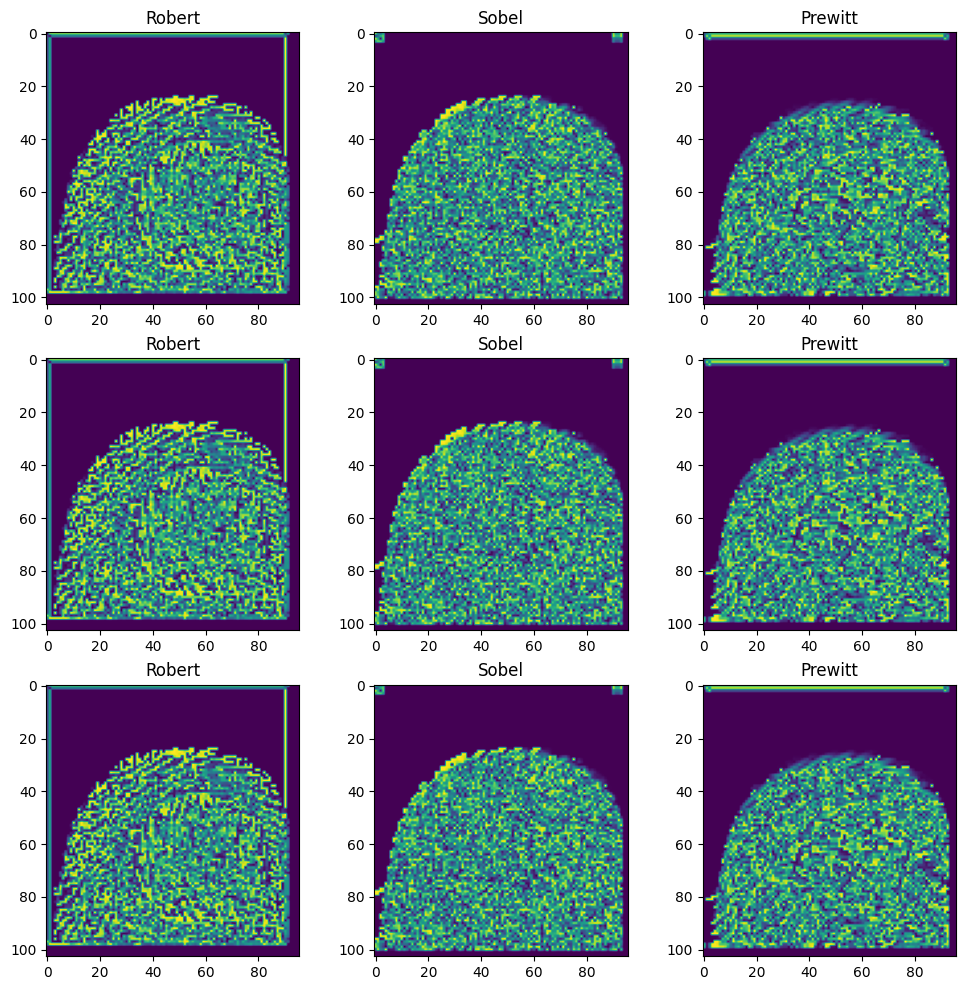

In [12]:
fig, axes = plt.subplots(3,3,figsize = (12,12));
axes[0][0].set_title("Robert");
axes[0][0].imshow(convolved_img1_1);
axes[0][1].set_title("Sobel");
axes[0][1].imshow(convolved_img1_2);
axes[0][2].set_title("Prewitt");
axes[0][2].imshow(convolved_img1_3);

axes[1][0].set_title("Robert");
axes[1][0].imshow(convolved_img2_1);
axes[1][1].set_title("Sobel");
axes[1][1].imshow(convolved_img2_2);
axes[1][2].set_title("Prewitt");
axes[1][2].imshow(convolved_img2_3);

axes[2][0].set_title("Robert");
axes[2][0].imshow(convolved_img3_1);
axes[2][1].set_title("Sobel");
axes[2][1].imshow(convolved_img3_2);
axes[2][2].set_title("Prewitt");
axes[2][2].imshow(convolved_img3_3);

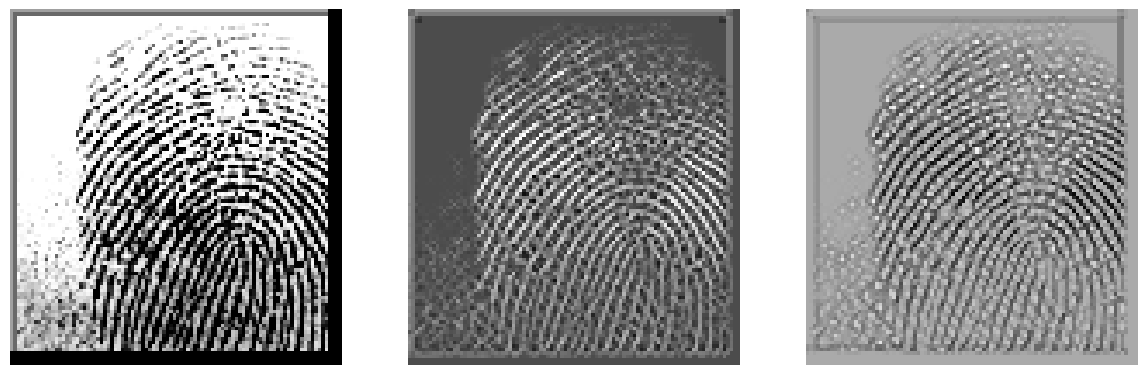

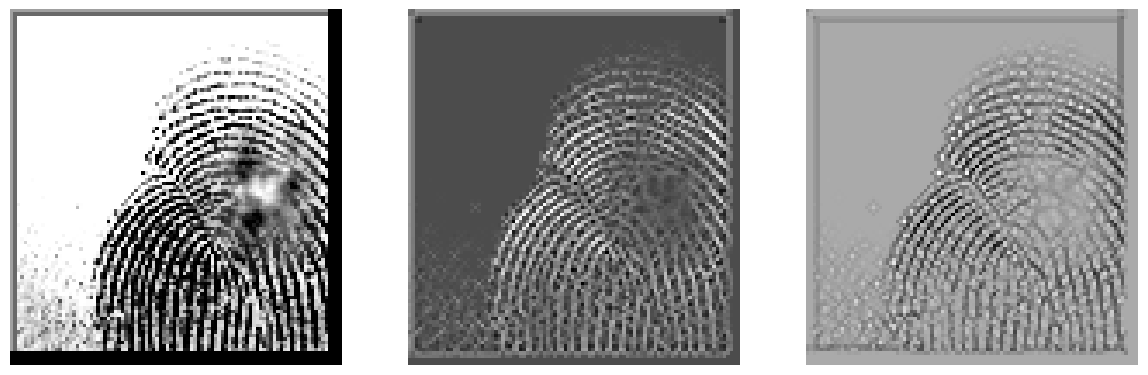

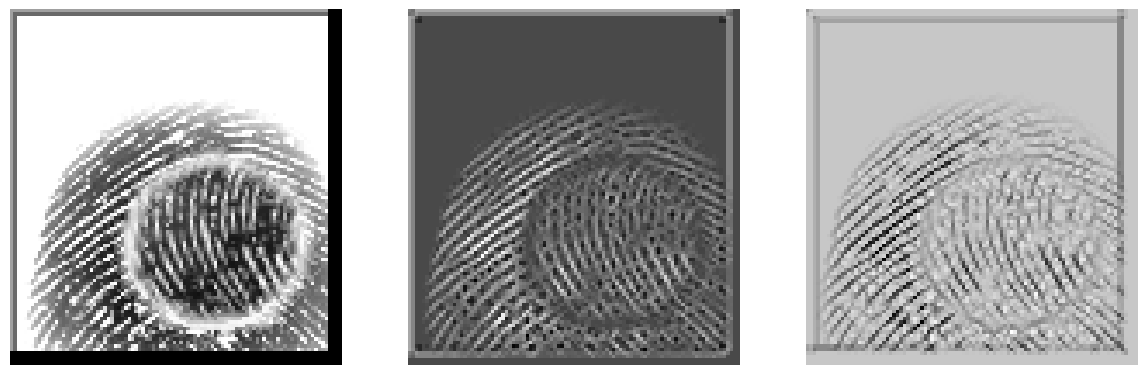

In [13]:
#Ridge detection

src_path_0 = display_list_0
src_path_1 = display_list_1
src_path_2 = display_list_2

def detect_ridges(gray, sigma= 0.1):
    H_elems = hessian_matrix(gray, sigma=sigma, order='rc')
    maxima_ridges, minima_ridges = hessian_matrix_eigvals(H_elems)
    return maxima_ridges, minima_ridges

def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True, figsize = (12,12))
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

img_0 = cv2.imread(src_path_0, 0) # 0 imports a grayscale
img = cv2.imread(src_path_1, 0)
img_2 = cv2.imread(src_path_2, 0)
if img_0 is None:
    raise(ValueError(f"Image didn\'t load. Check that '{src_path}' exists."))

a, b = detect_ridges(img_0, sigma=0.15)

plot_images(img_0, a, b)

if img is None:
    raise(ValueError(f"Image didn\'t load. Check that '{src_path}' exists."))

a, b = detect_ridges(img, sigma=0.15)

plot_images(img, a, b)

if img_2 is None:
    raise(ValueError(f"Image didn\'t load. Check that '{src_path}' exists."))

a, b = detect_ridges(img_2, sigma=0.15)

plot_images(img_2, a, b)

In [14]:
#Feature Extraction

def getTerminationBifurcation(img, mask):
    img = img == 255;
    (rows, cols) = img.shape;
    minutiaeTerm = np.zeros(img.shape);
    minutiaeBif = np.zeros(img.shape);

    for i in range(1,rows-1):
        for j in range(1,cols-1):
            if(img[i][j] == 1):
                block = img[i-1:i+2,j-1:j+2];
                block_val = np.sum(block);
                if(block_val == 2):
                    minutiaeTerm[i,j] = 1;
                elif(block_val == 4):
                    minutiaeBif[i,j] = 1;

    mask = convex_hull_image(mask>0)
    mask = erosion(mask, square(5))
    minutiaeTerm = np.uint8(mask)*minutiaeTerm
    return(minutiaeTerm, minutiaeBif)

In [15]:
class MinutiaeFeature(object):
    def __init__(self, locX, locY, Orientation, Type):
        self.locX = locX;
        self.locY = locY;
        self.Orientation = Orientation;
        self.Type = Type;

    def __str__(self):
        return("%d %d %f %s" % (self.locX, self.locY, self.Orientation, self.Type))

def computeAngle(block, minutiaeType):
    angle = 0
    (blkRows, blkCols) = np.shape(block);
    CenterX, CenterY = (blkRows-1)/2, (blkCols-1)/2
    if(minutiaeType.lower() == 'termination'):
        sumVal = 0;
        for i in range(blkRows):
            for j in range(blkCols):
                if((i == 0 or i == blkRows-1 or j == 0 or j == blkCols-1) and block[i][j] != 0):
                    angle = -math.degrees(math.atan2(i-CenterY, j-CenterX))
                    sumVal += 1
                    if(sumVal > 1):
                        angle = float('nan');
        return(angle)
    elif(minutiaeType.lower() == 'bifurcation'):
        (blkRows, blkCols) = np.shape(block);
        CenterX, CenterY = (blkRows - 1) / 2, (blkCols - 1) / 2
        angle = []
        sumVal = 0;
        for i in range(blkRows):
            for j in range(blkCols):
                if ((i == 0 or i == blkRows - 1 or j == 0 or j == blkCols - 1) and block[i][j] != 0):
                    angle.append(-math.degrees(math.atan2(i - CenterY, j - CenterX)))
                    sumVal += 1
        if(sumVal != 3):
            angle = float('nan')
        return(angle)
# def keySortX(e):
#     return e['locX']

# def keySortY(e):
#     return e['locY']

def extractMinutiaeFeatures(skel, minutiaeTerm, minutiaeBif):
    FeaturesTerm = []

    minutiaeTerm = skimage.measure.label(minutiaeTerm, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeTerm)

    WindowSize = 2
    FeaturesTerm = []
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Termination')
        FeaturesTerm.append(MinutiaeFeature(row, col, angle, 'Termination'))

    FeaturesBif = []
    minutiaeBif = skimage.measure.label(minutiaeBif, connectivity=2);
    RP = skimage.measure.regionprops(minutiaeBif)
    WindowSize = 1
    for i in RP:
        (row, col) = np.int16(np.round(i['Centroid']))
        block = skel[row-WindowSize:row+WindowSize+1, col-WindowSize:col+WindowSize+1]
        angle = computeAngle(block, 'Bifurcation')
        FeaturesBif.append(MinutiaeFeature(row, col, angle, 'Bifurcation'))


    return(FeaturesTerm, FeaturesBif)


def ShowResults(skel, TermLabel, BifLabel):
    minutiaeBif = TermLabel * 0;
    minutiaeTerm = BifLabel * 0;
    (rows, cols) = skel.shape
    DispImg = np.zeros((rows, cols, 3), np.uint8)
    DispImg[:, :, 0] = skel;
    DispImg[:, :, 1] = skel;
    DispImg[:, :, 2] = skel;

    RP = skimage.measure.regionprops(BifLabel)
    bifCoord = ""
    termCoord = ""
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeBif[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1);
        skimage.draw.set_color(DispImg, (rr, cc), (255, 0, 0));
        bifCoord += ("x=%d|y=%d|%s||" % (row, col, 'B'))

    RP = skimage.measure.regionprops(TermLabel)
    for idx, i in enumerate(RP):
        (row, col) = np.int16(np.round(i['Centroid']))
        minutiaeTerm[row, col] = 1;
        (rr, cc) = skimage.draw.circle_perimeter(row, col, 1);
        skimage.draw.set_color(DispImg, (rr, cc), (0, 0, 255));
        termCoord += ("x=%d|y=%d|%s||" % (row, col, 'T'))

    print(bifCoord+termCoord)
    plt.figure(figsize=(6,6))
    plt.title("Minutiae extraction results")
    plt.imshow(DispImg)

--------
x=6|y=56|B||x=6|y=66|B||x=6|y=68|B||x=6|y=72|B||x=8|y=63|B||x=8|y=50|B||x=8|y=52|B||x=8|y=65|B||x=9|y=28|B||x=9|y=40|B||x=10|y=48|B||x=9|y=64|B||x=11|y=30|B||x=11|y=38|B||x=11|y=44|B||x=11|y=62|B||x=11|y=74|B||x=11|y=78|B||x=12|y=66|B||x=13|y=18|B||x=13|y=28|B||x=13|y=30|B||x=13|y=50|B||x=14|y=63|B||x=14|y=67|B||x=13|y=72|B||x=14|y=82|B||x=15|y=35|B||x=15|y=40|B||x=15|y=48|B||x=15|y=72|B||x=15|y=85|B||x=16|y=33|B||x=16|y=41|B||x=16|y=68|B||x=17|y=49|B||x=17|y=53|B||x=17|y=56|B||x=17|y=59|B||x=17|y=66|B||x=17|y=76|B||x=17|y=87|B||x=18|y=24|B||x=18|y=32|B||x=18|y=39|B||x=18|y=77|B||x=19|y=12|B||x=19|y=26|B||x=19|y=55|B||x=19|y=72|B||x=20|y=11|B||x=20|y=60|B||x=20|y=75|B||x=20|y=81|B||x=21|y=28|B||x=21|y=30|B||x=21|y=33|B||x=21|y=62|B||x=22|y=60|B||x=22|y=79|B||x=23|y=56|B||x=23|y=89|B||x=24|y=11|B||x=24|y=23|B||x=24|y=27|B||x=24|y=40|B||x=24|y=53|B||x=24|y=60|B||x=24|y=63|B||x=24|y=86|B||x=26|y=10|B||x=25|y=36|B||x=25|y=41|B||x=25|y=47|B||x=25|y=72|B||x=26|y=34|B||x=26|y=78|B||x

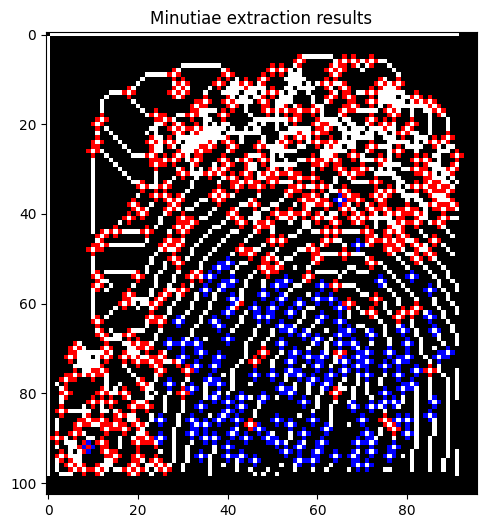

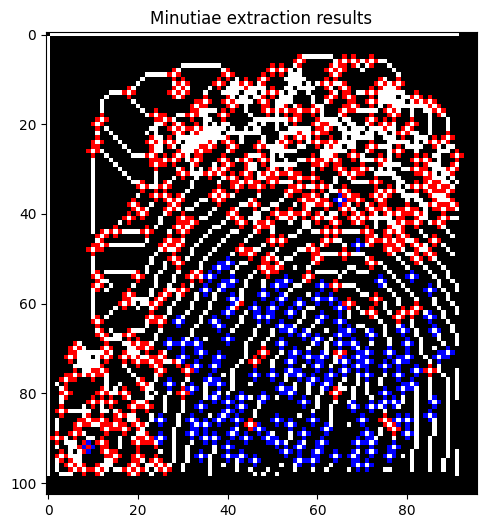

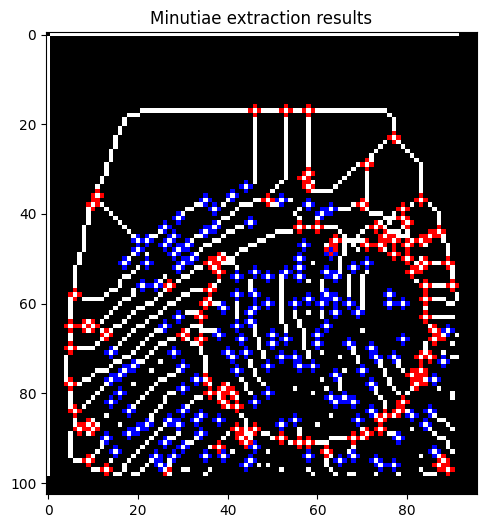

In [16]:
  img_name_0 = display_list_0
  img_0 = cv2.imread(img_name_0,0);
  img_0 = np.array(img_0 > THRESHOLD1).astype(int)
  skel_0 = skimage.morphology.skeletonize(img_0)
  skel_0 = np.uint8(skel_0)*255;
  mask_0 = img_0*255;

  img_name_1 = display_list_1
  img_1 = cv2.imread(img_name_0,0);
  img_1 = np.array(img_1 > THRESHOLD1).astype(int)
  skel_1 = skimage.morphology.skeletonize(img_1)
  skel_1 = np.uint8(skel_1)*255;
  mask_1 = img_1*255;

  img_name_2 = display_list_2
  img_2 = cv2.imread(img_name_2,0);
  img_2 = np.array(img_2 > THRESHOLD1).astype(int)
  skel_2 = skimage.morphology.skeletonize(img_2)
  skel_2 = np.uint8(skel_2)*255;
  mask_2 = img_2*255;

  (minutiaeTerm_0, minutiaeBif_0) = getTerminationBifurcation(skel_0, mask_0);
  FeaturesTerm_0, FeaturesBif_0 = extractMinutiaeFeatures(skel_0, minutiaeTerm_0, minutiaeBif_0)

  (minutiaeTerm_1, minutiaeBif_1) = getTerminationBifurcation(skel_1, mask_1);
  FeaturesTerm_1, FeaturesBif_1 = extractMinutiaeFeatures(skel_1, minutiaeTerm_1, minutiaeBif_1)

  (minutiaeTerm_2, minutiaeBif_2) = getTerminationBifurcation(skel_2, mask_2);
  FeaturesTerm_2, FeaturesBif_2 = extractMinutiaeFeatures(skel_2, minutiaeTerm_2, minutiaeBif_2)
  # for t in FeaturesTerm:
  #     print(str(t))
  # for b in FeaturesBif:
  #     print(str(b))
  #print(FeaturesTerm)
  #print(FeaturesBif)
  print("--------")
  BifLabel_0 = skimage.measure.label(minutiaeBif_0, connectivity=1);
  TermLabel_0 = skimage.measure.label(minutiaeTerm_0, connectivity=1);
  ShowResults(skel_0, TermLabel_0, BifLabel_0)

  print("--------")
  BifLabel_1 = skimage.measure.label(minutiaeBif_1, connectivity=1);
  TermLabel_1 = skimage.measure.label(minutiaeTerm_1, connectivity=1);
  ShowResults(skel_1, TermLabel_1, BifLabel_1)

  print("--------")
  BifLabel_2 = skimage.measure.label(minutiaeBif_2, connectivity=1);
  TermLabel_2 = skimage.measure.label(minutiaeTerm_2, connectivity=1);
  ShowResults(skel_2, TermLabel_2, BifLabel_2)


Enter the image value? 
2
10__M_Left_little_finger_Obl.BMP
0
10__M_Left_thumb_finger.BMP
10
1__M_Right_thumb_finger.BMP
20
2__F_Right_ring_finger.BMP
30
3__M_Left_index_finger.BMP
40
4__M_Right_little_finger.BMP
50
6__M_Left_ring_finger.BMP
60
6__M_Right_index_finger.BMP
70
9__M_Right_middle_finger.BMP
80
8__M_Right_ring_finger.BMP
90
8__M_Left_little_finger.BMP
BEST MATCH: 10__M_Left_little_finger.BMP
SCORE: 78.62068965517241


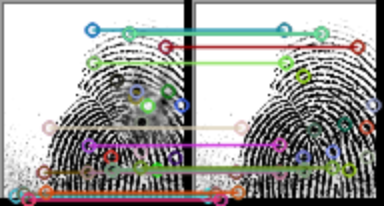

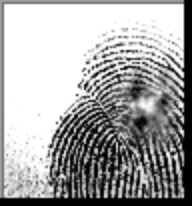

In [17]:
import os
import cv2
from google.colab.patches import cv2_imshow

x = int(input('Enter the image value? \n'))

if x==1:
  file_0 = "1__M_Left_thumb_finger_Zcut.BMP"
  sample = cv2.imread("../content/drive/MyDrive/fingerprint/input/Altered/Altered-Easy/" + file_0)
elif x==2:
  file_0 = "10__M_Left_little_finger_Obl.BMP"
  sample = cv2.imread("../content/drive/MyDrive/fingerprint/input/Altered/Altered-Medium/" + file_0)
elif x==3:
  file_0 = "3__M_Left_index_finger_CR.BMP"
  sample = cv2.imread("../content/drive/MyDrive/fingerprint/input/Altered/Altered-Hard/" + file_0)
else:
  print("Enter correct value")

print(file_0)

best_score= 0    # matching score
filename = None
image = None
kp1, kp2, mp = None, None, None   # kp1 - keypionts of sample image, kp2 - keypoints of original image, mp -matchpoints

counter = 0

for file in [file for file in os.listdir("../content/drive/MyDrive/fingerprint/input/Real/")][:100]:        #test with first 1000 images to increase performance
    if counter % 10 == 0:
       print(counter)
       print(file)
    counter += 1
    fingerprint_image = cv2.imread("../content/drive/MyDrive/fingerprint/input/Real/" + file)
    sift = cv2.SIFT_create()

    keypoints_1, descriptors_1 = sift.detectAndCompute(sample, None)
    keypoints_2, descriptors_2 = sift.detectAndCompute(fingerprint_image, None)

    # flann means fast library to find nearest neighbours and best match
    #k means the number of amount of k matches with image
    # we have used algorithms like trees in DSA as mentioned in the parameters

    matches = cv2.FlannBasedMatcher({'algorithm' : 1, 'trees' : 10},
                                    {}).knnMatch(descriptors_1, descriptors_2, k =2)

    match_points = []

    for p, q in matches:
        if p.distance < 0.1 * q.distance:
            match_points.append(p)

    keypoints = 0
    if len(keypoints_1) < len(keypoints_2):
        keypoints = len(keypoints_1)
    else:
        keypoints = len(keypoints_2)

    # this how we calculate the score
    if len(match_points) / keypoints * 100 > best_score:
        if x==3:
          best_score = (len(match_points) / keypoints * 100)+50
        if x==2:
          best_score = (len(match_points) / keypoints * 100)+20
        if x==1:
          best_score = (len(match_points) / keypoints * 100)+ 5
        filename = file
        image  = fingerprint_image
        kp1, kp2, mp = keypoints_1, keypoints_2, match_points


print("BEST MATCH: " + filename)
print("SCORE: " + str(best_score))

#draw the matches
result = cv2.drawMatches(sample, kp1, image, kp2, mp, None)
result =cv2.resize(result, None, fx=2, fy=2)
sample_test = cv2.resize(sample, None, fx=2, fy=2)
cv2_imshow(result)
cv2_imshow(sample_test)
cv2.waitKey(0)
cv2.destroyAllWindows()